In [47]:
import os
from typing import Annotated

from typing_extensions import TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic
from langsmith import utils 

# 환경 변수 로드
load_dotenv()

utils.tracing_is_enabled()

True

# Build a Basic Chatbot

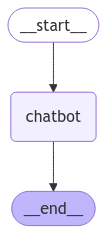

In [2]:


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


graph_builder = StateGraph(State)

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

# 엔트리 포인트 설정, 그래프가 실행될 때 어디서부터 시작할지 정의하는 역할할
graph_builder.add_edge(START, "chatbot")

# 피니쉬 포인트 설정, 그래프가 종료될 때 어디서 끝낼지 정의하는 역할
graph_builder.add_edge("chatbot", END)

# compilie 메서드 호출로 그래프를 컴파일 -> CompliledGraph 객체가 생성됨
# CompliledGraph 객를 이용하면, 우리가 만든 상태(State) 그래프를 실행(invoke)할 수 있음
graph = graph_builder.compile()


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [3]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break
    finally:
        print(" **** 1 cycle done ****")

Assistant: Hello! How can I help you today? If you have any questions or need assistance with English, I'm here to help. Just let me know what you need.
 **** 1 cycle done ****
Goodbye!
 **** 1 cycle done ****


# Enhancing the Chatbot with Tools

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
# Tavily 검색 엔진을 사용 
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'Nodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as:.'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step . You define nodes to perform'}]

In [37]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [38]:
# State는 전체 애플리케이션의 현재 상태를 나타내는 공유 데이터 구조
# 전체 워크플로우의 컨텍스트 유지; 노드 간 정보 공유; TypedDict 또는 Pydantic BaseModel로 정의 

# 모든 정보 실시간 업데이트, 그래프 내에서 이 상태가 모든 직원(Agent)에게 공유 가능
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [39]:
llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# LLM에 bind_tools 기능을 추가
# bind_tools를 추가하면 LLM이 검색 엔진을 사용할 때 올바른 JSON 형식을 따르도록 알려줌
# 즉, LLM이 검색 엔진과 올바르게 상호작용할 수 있도록 설정하는 과정
llm_with_tools = llm.bind_tools(tools)

In [40]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## BasicToolNode 구현
역할
- 현재 상태의 가장 최근 메시지 확인
- 메시지에 tool_calls 정보가 포함되어 있다면, 도구 실행
- 이 과정에서 llm의 tool_calling 기능 활용

## Tool_calling
- 최신 LLM은 외부 도구를 자동으로 호출하는 기능을 지원
- 즉, 챗봇이 직접 웹 검색, 계산기, API 호출 등 다양한 도구를 필요에 따라 실행

## BasicToolNode - > ToolNode
- 지금은 직접 BasicToolNode를 구현하여 원리를 이해하지만, 나중에는 랭그래프의 ToolNode를 사용 

In [41]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}



In [42]:

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## 도구 노드가 추가되면, 조건부 엣지(Conditional Edges)를 정의해야 함
- 엣지(edges) : 그래프의 노드 간의 흐름제어 하는 역할
- 조건부 엣지는 if 문을 포함하여 특정 조건에 따라 다른 노드로 이동할 수 있도록 함 

## 조건부 엣지 역할
- 현재 그래프 상태(graph state) 받아옴
- 어떤 노드로 이동할지 결정하는 라우팅함수 실행
- 라우팅 함수는 문자열 또는 문자열 리스트 반환, 이는 다으멩 실행할 노드의 이름을 나타냄 

In [43]:
# 챗봇의 응답 확인하고, tool_calls 포함되어 있는지 확인
# tool_calls가 포함되어 있으면 tools로 라우팅, 그렇지 않으면 END로 라우팅 

# 직접 route_tools를 구현하여 원리를 이해
# 나중에는 langgraph의 tools_condition을 사용하여 더 간단하게 구현 가능 
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# `tools_condition` 함수는 챗봇이 도구를 사용해야 한다고 판단하면 "tools"를 반환하고,  
# 직접 응답해도 괜찮다면 "END"를 반환 
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # 아래 딕셔너리를 사용하면 그래프가 조건의 출력을 특정 노드로 해석하도록 설정
    # 기본값은 identity function(입력을 그대로 반환)이며,  
    # 만약 "tools"라는 노드 대신 다른 노드 이름을 사용하고 싶다면,  
    # 예를 들어 "tools": "my_tools"로 변경할 수 있음 
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

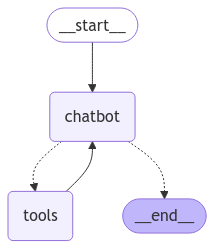

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [46]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://blog.naver.com/wild_it/223268788749", "content": "\uc708\ub3c4\uc6b0 11\uc5d0 \uc544\uc774\ud3f0\uc744 \uc5f0\uacb0\ud558\uae30 \uc704\ud574\uc11c\ub294 \ubcc4\ub3c4 \ud504\ub85c\uadf8\ub7a8\uc744 \ub2e4\uc6b4\ub85c\ub4dc\ud560 \ud544\uc694\uac00 \uc5c6\uc2b5\ub2c8\ub2e4. \u200b. \uba3c\uc800 \uc5f0\uacb0\uc5d0 \ud544\uc694\ud55c \ud504\ub85c\uadf8\ub7a8\uc744 \uc2e4\ud589\uc2dc\ucf1c\ubcf4\uaca0\uc2b5\ub2c8\ub2e4. \ud558\ub2e8"}, {"url": "https://blog.naver.com/culture-box/223551367798", "content": "\uc6b0\ub9ac\uac00 \uc138\uc6b4 \uacc4\ud68d\uc740 \uc5b4\ub5bb\uac8c \ub3fc? \u200b. The internet's gone wild watching movie stars on trial. \ub514 \uc778\ud130\ub137\uc2a4 \uac74 \uc640\uc77c\ub4dc \uc6cc\uce58\uc789 \ubb34\ube44 \uc2a4\ud0c0\uc988 \uc628 \ud2b8\ub77c\uc774\uc5bc."}]
Assistant: 네이버 블로거 "와일딧"은 "[https://blog.naver.com/wild\_it/223268788749](https://blog.naver.com/wild_it/223268788749)"와 "[https://blog.naver.com/culture-box/22355136

# 챗봇에 기억(Memory) 추가
- LangGraph의 해결 방법: 지속적인 체크포인트(Persistent Checkpointing)

✅ 체크포인트 기능의 원리
1. 그래프를 컴파일할 때, "체크포인터(Checkpointer)"를 제공하면 됩니다.
2. 그래프를 실행할 때, "thread_id"를 제공하면 됩니다.
3. LangGraph는 자동으로 각 단계 이후에 상태(State)를 저장합니다.
4. 같은 "thread_id"로 그래프를 다시 실행하면, 이전 상태가 로드됩니다.
5. 이전 대화 내용을 기억한 상태로 새로운 대화를 이어갈 수 있습니다. 🗂

 # LangGraph의 체크포인트 기능이 단순한 "챗봇 메모리"보다 강력한 이유

1. 복잡한 상태(State) 저장 및 복원 가능
    - 단순한 메시지 기록이 아니라, 챗봇이 사용한 도구, 중간 계산 결과 등을 저장 가능
2. 오류 복구(Error Recovery)
    - 특정 지점에서 실행이 실패해도, 중단된 지점에서 다시 시작할 수 있음

3. Human-in-the-loop 워크플로우
    - 사람이 중간에 개입하여 챗봇의 진행을 조정할 수 있음

4. 시간 여행(Time Travel) 인터랙션
    -  과거 상태를 복원하여 이전에 했던 대화를 다시 이어나갈 수 있음


In [11]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [12]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [13]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_with_tools =  llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)


tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [14]:
# 체크포인터를 추가해 그래프를 최종 컴파일
graph = graph_builder.compile(checkpointer=memory)

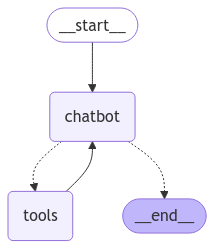

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
config = {"configurable": {"thread_id": "1"}}

In [17]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_xgrh)
 Call ID: call_xgrh
  Args:
    query: Who is Will?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://vampirediaries.fandom.com/wiki/Will", "content": "He was a vampire and underling of Katherine Pierce. He has a history with Damon. He originally planned to attack Hayley but was bitten by Klaus and ran off."}, {"url": "https://www.cdcfoundation.org/give/will", "content": "A will, or a last will and testament, is a legal document that describes how you would like your property and other assets to be distributed after your death."}]
================================== Ai Message ==================================

It seems that "Will" is both a common name and a term u

In [18]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name. You introduced yourself as Will. How can I assist you today?


## 스냅샷 포함 정보
1. 현재 상태값
    - 챗봇이 저장한 대화 상태 데이터

2. 해당 구성(config)
    - 그래프 실행에 사용된 설정 정보

3.  다음으로 처리할 노드
    - 현재 그래프가 진행 중인 경우, 다음 실행될 노드 정보

In [19]:
# 두 개의 다른 스레드에 거렻 어러 개의 체크포인트를 만들었음
# 특정 config에 대한 그래프의 상태를 언제든지 확인하려면 , get_state 메서드를 사용 
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='1a7b25ac-de9b-4f51-b4f6-d0bfe3f1c0aa'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xgrh', 'function': {'arguments': '{"query":"Who is Will?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 1213, 'total_tokens': 1310, 'completion_time': 0.149099323, 'prompt_time': 0.063879001, 'queue_time': 0.018802801999999993, 'total_time': 0.212978324}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b8d6f119-4313-4b71-a4f7-dc8aa2a614c8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Who is Will?'}, 'id': 'call_xgrh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1213, 'output_tokens': 97, 'total_tokens': 1310}), ToolMessage(content=

In [26]:
# 현재 그래프 END 상태에 도달했기때문에, next 메서드를 호출하면 더 이상의 이벤트가 없음,
# 즉, 더 이상 실행할 단계가 없음
snapshot.next

()

# 인간 개입 추가
- 일부 중요한 작업 실행전, 인간의 승인 요구
- 에이전트는 완벽하지 않음, 인간의 입력 필요할 수 있음


## 🔹 핵심 기능: interrupt() 함수
- ✅ interrupt()란?
    - LangGraph에서 "Human-in-the-loop"를 구현하는 주요 기능
    - 특정 노드에서 interrupt()를 호출하면 현재 실행이 중지(Pause)
    - 이후, 사용자의 추가 입력과 함께 실행이 다시 시작(Resume)
    - 이는 Python의 input() 함수와 유사하지만, 일부 차이점(caveats) 있음


## 실행 흐름
1. 특정 노드에서 interrup() 호출하면 실행 일시 중지
2. 사용자가 새로운 입력 제공
3. LangGraph가 해당 입력 적용한 후 실행 재개

In [6]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # 도구 실행 중에 중단(interrupt)할 것이므로,
    # 병렬 도구 호출(parallel tool calling)을 비활성화합니다.
    # 이를 통해 실행을 다시 시작할 때 동일한 도구 호출이 반복되지 않도록 방지합니다.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [7]:
# 체크포인터를 추가해 그래프를 최종 컴파일
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

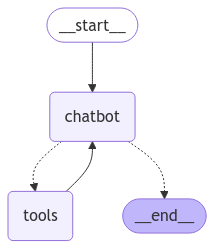

In [8]:
# 시각화 
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_184y)
 Call ID: call_184y
  Args:
    query: Expert guidance for building an AI agent


In [ ]:
# 그래프 상태를 살펴보면, 현재 실행이 tools 노드에서 멈춘 상태임을 확인할 수 있음
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [11]:
# 실행을 다시 시작하려면, 도구가 예상하는 데이터를 포함하는 Command 객체를 전달해야함
# 이 데이터의 형식은 사용자의 필요에 따라 맞춤 설정할 수 있음
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_184y)
 Call ID: call_184y
  Args:
    query: Expert guidance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


# 상태(STATE) 커스터마이징

In [48]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt



class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


@tool
# 상태(state) 업데이트를 위한 `ToolMessage`를 생성하고 있기 때문에,  
# 일반적으로 해당 도구 호출(tool call)에 대한 ID가 필요
# LangChain의 `InjectedToolCallId`를 사용하면,  
# 이 인자가 도구의 스키마(schema)에서  
# 모델에게 공개되지 않도록 설정할 수 있습니다.

def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # 만약 정보가 올바르면, 그대로 상태(state)를 업데이트함.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # 그렇지 않으면, 인간 검토자가 제공한 수정된 정보를 반영함.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # 이번에는 도구(tool) 내부에서 `ToolMessage`를 사용하여 상태를 명시적으로 업데이트함.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # 도구 내부에서 `Command` 객체를 반환하여 상태(state)를 업데이트함.
    return Command(update=state_update)


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(
    # model="mixtral-8x7b-32768",
    model="llama-3.1-8b-instant",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
# 수동으로 상태 업데이트 
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}
# {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'} 